In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import time as tm

## Variables de decisión de 1er etapa
$$x^{ij}_1 = \left\lbrace \begin{array}{lc} 1 & \text{Si el individio j pertence al grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$
$$y^{i}_1 = \left\lbrace \begin{array}{lc} 1 & \text{Si hay individuos en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$
$$z^{i}_1 = \left\lbrace \begin{array}{lc} 1 & \text{Si hay más de un individuo en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

## Variables de decisión de 2da etapa

$$x^{ij}_2 = \left\lbrace \begin{array}{lc} 1 & \text{Si el individio enfermo j pertence al grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

$$ y^{i}_{2} = \left\lbrace \begin{array}{lc} 1 & \text{Si hay individuos enfermos en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

$$ z^{ij}_{2} = \left\lbrace \begin{array}{lc} 1 & \text{Si se hace un test sobre el individuo i del grupo j}\\ 0 & \text{En otro caso} \end{array} \right.$$


$$x^{ij}_{3} = \left\lbrace \begin{array}{lc} 1 & \text{Si el individio enfermo no testeado j pertence al grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

$$ y^{i}_{3} = \left\lbrace \begin{array}{lc} 1 & \text{Si hay individuos enfermos no testeados en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

$$ z_{3}^i = \left\lbrace \begin{array}{lc} 1 & \text{Si el individuo i está enfermo y no testeado}\\ 0 & \text{En otro caso} \end{array} \right. $$


## Restricciones

1. Relación de variables de decisión x e y.
$$ $$

2. Relación entre las variables x, z.
$$ $$

3. Todos los individuos tiene que estar en un grupo.
$$ $$

4. La cantidad de grupos nos puede superar la cantidad de tests posibles.
$$ $$

5. El grupo necesita cumplir el volumen de muestra minimo para que se realice un test.
$$ $$

6. Si el individuo no tiene más de un umbral de muestra delta, entonces se realice un test individual inmediatamente.
$$ $$

7. La cantidad total de grupos de test (sin contar los test individuales) no puede superar a la cantidad de individuos dividida por el número de group testing.
$$ $$

8. La cantidad de individuos que conforman los grupos de test debe ser mayor o igual a la población total.

$$ $$
9. Si la probabilidad de infección del individuo supera la probabilidad $p=0.3$ entonces se le hace un test individual (no implementado).


## Metodología de Sterret

In [67]:
def SterretStage1(model, where):

    if where == gp.GRB.Callback.MIPSOL:
        print("asd")
        EQ = 0
        sub = {}
        # x2 = {}
        # y2 = {}
        # z2 = {}
        # theta2 = {}
        # print(model.getVars())
        # print(x2[list(x2)[-1]])
        
        # print( model.cbGetSolution(x2[list(x2)[-1]][0,0]) )

        if sum([sum([model.cbGetSolution(x2[list(x2)[-1]][i,j]) for j in individuos]) for i in grupos]) >= 0:
            for s in escenarios:
                # ret = np.random.binomial(n=1, p=p, size=I)
                sub[s] = gp.Model()
                sub[s].params.OutputFlag = 0

                x1 = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x2") # grupos de x1 que salieron +
                y1 = sub[s].addVars(grupos, vtype=gp.GRB.BINARY, name="y2") # grupos + de x1
                z1 = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="z2") # ind de grupos + que fueron testeados individualmente
                theta = sub[s].addVar(lb=0)

                sub[s].addConstrs((model.cbGetSolution(z3[j]) == 1) >> (sum(x1[i,j] for i in grupos) >= 1) for j in individuos)
                sub[s].addConstrs((model.cbGetSolution(z3[j]) == 0) >> (sum(x1[i,j] for i in grupos) == 0) for j in individuos)

                sub[s].addConstrs(y1[i]*1e6 >= sum(x1[i, j] for j in individuos) for i in grupos)
                sub[s].addConstrs(z1[i]*1e6 >= sum(x1[i, j] for j in individuos) - 1 for i in grupos)

                sub[s].addConstrs(sum(x1[i, j] for j in individuos) <= GT for i in grupos)
                sub[s].addConstr(sum(x1[i, j] for i in grupos for j in individuos) >= sum(model.cbGetSolution(z3[j]) for j in individuos))
                sub[s].addConsts(sum(x1[i, j] for i in grupos) == 1 for j in individuos)
                # sub[s].addConstr(sum(y1[i] for i in grupos) <= alpha)

                sub[s].setObjective(sum(y1[j] for j in grupos) + theta, gp.GRB.MINIMIZE)

                # sub[s].optimize(SterretStage2)
                sub[s].optimize()
                
                EQ += sub[s].objVal
            EQ = EQ/S


            model.cbLazy(EQ <= theta)


In [68]:
def SterretStage2(model, where):
    global x2
    if where == gp.GRB.Callback.MIPSOL:
        EQ = 0
        sub = {}
        # x2 = {}
        for s in escenarios:
            # ret = np.random.binomial(n=1, p=p, size=I)
            sub[s] = gp.Model()
            sub[s].params.OutputFlag = 0

            x2[s] = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x2") 
            y2 = sub[s].addVars(grupos, vtype=gp.GRB.BINARY, name="y2") 
            z2 = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="z2") 

            # hat_x2 = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="hx2") # grupos de ind sobrantes
            x3 = sub[s].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x3")
            y3 = sub[s].addVars(grupos, vtype=gp.GRB.BINARY, name="y3")
            z3 = sub[s].addVars(individuos, vtype=gp.GRB.BINARY, name="z3")

            # sub[s].addConstrs(sum(x2[i,j] for j in individuos) <= GT for i in grupos)
            sub[s].addConstrs(y2[i]*1e6 >= sum(model.cbGetSolution(x1[GT][i,j])*ret[s][j] for j in individuos) for i in grupos)
            sub[s].addConstrs(x2[s][i,j] >= model.cbGetSolution(x1[GT][i,j])*y2[i] + model.cbGetSolution(z1[GT][i])-1 for j in individuos for i in grupos)
            sub[s].addConstrs(x2[s][i,j] <= model.cbGetSolution(x1[GT][i,j])*y2[i] for j in individuos for i in grupos)


            sub[s].addConstrs(z2[i,j] >= x2[s][i,j]-sum(x2[s][i,k]*ret[s][k] for k in range(j-1)) for j in range(1,I) for i in grupos)
            sub[s].addConstrs(z2[i,0] >= x2[s][i,0]*(1-ret[s,i]) for i in grupos)

            sub[s].addConstrs(x3[i,j] == x2[s][i,j] - z2[i,j] for j in individuos for i in grupos)
            sub[s].addConstrs(y3[i]*1e6 >= sum(x3[i,j] for j in individuos) for i in grupos)
            
            sub[s].addConstrs(z3[j] == sum(x3[i,j] for i in grupos) for j in individuos)


            sub[s].setObjective(sum(z2[i, j] for i in grupos for j in individuos) + sum(y3[i] for i in grupos), gp.GRB.MINIMIZE)

            sub[s].optimize(SterretStage1)
            # sub[s].optimize()

            # print("X1")
            # M = np.zeros((G, I))
            # for j in range(I):
            #     for i in range(G):
            #         M[i,j] = model.cbGetSolution(x1[GT][i,j])
            # plt.spy(M)
            # plt.show()

            # print("X2")
            # M = np.zeros((G, I))
            # i, j = -1, -1
            # for var in sub[s].getVars():
            #     if "x2" in var.VarName:
            #         j += 1
            #         if j % I == 0:
            #             i += 1
            #             j = 0
            #         if var.X == 1:
            #             M[i, j] = 1
            # plt.spy(M)
            # plt.show()
            # plt.spy(np.matrix(ret[s,:]))
            # plt.show()

            # print("Z2")
            # M = np.zeros((G, I))
            # i, j = -1, -1
            # for var in sub[s].getVars():
            #     if "z2" in var.VarName:
            #         j += 1
            #         if j % I == 0:
            #             i += 1
            #             j = 0
            #         if var.X == 1:
            #             M[i, j] = 1
            # plt.spy(M)
            # plt.show()
            # print("X3")
            # M = np.zeros((G, I))
            # i, j = -1, -1
            # for var in sub[s].getVars():
            #     if "x3" in var.VarName:
            #         j += 1
            #         if j % I == 0:
            #             i += 1
            #             j = 0
            #         if var.X == 1:
            #             M[i, j] = 1
            # plt.spy(M)
            # plt.show()
    

            EQ += sub[s].objVal

        EQ = EQ/S


        model.cbLazy(EQ <= theta[GT])


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


asd


NameError: name 'z3' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in SterretStage1
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_2180\846679220.py", line 27, in <genexpr>
NameError: name 'z3' is not defined


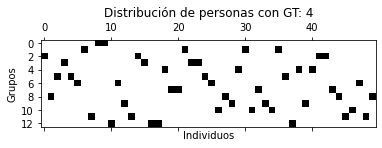

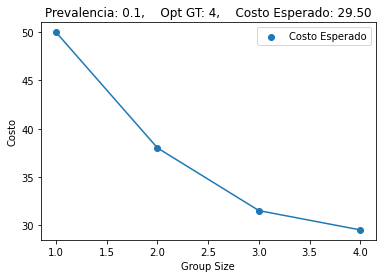

Tiempo de ejecución:  6.47s


In [69]:
I = 50  # Cantidad de personas
alpha = 50  # Cantidad de test disponibles
beta = 0.2  # Cantidad de muestras que necesita un test
delta = 0.3  # Umbral para solo testear
individuos = range(I)
muestras = 2*np.ones(I)
S = 2
escenarios = range(S)

prevalencia = [0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.11, 0.12, 0.13, 0.15, 0.20, 
                0.25, 0.30]

prevalencia = [0.1]
# S = 5
# I = 50

costo = []
gt_opt = []


t1 = tm.time()
for p in prevalencia:
    hat_p = np.ones(I)*p
    
    ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])
    val = []

    x1 = {}
    y1 = {}
    z1 = {}
    x2 = {}
    y2 = {}
    z2 = {}
    x3 = {}
    y3 = {}
    z3 = {}
    
    theta = {}
    master = {}

    for GT in range(1,5):
        G = int(np.ceil(I/GT))
        grupos = range(G)
        L = 0
        
        master[GT] = gp.Model()
        master[GT].params.OutputFlag = 0
        master[GT].params.LazyConstraints = 1

        x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
        y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
        z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
        theta[GT] = master[GT].addVar(lb=L)

        master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
        master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
        master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) == 1 for j in individuos) #R3 == or >= ****
        # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4

        master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
        master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

        master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

        master[GT].optimize(SterretStage2)
        val.append(master[GT].objVal)

        
    GTO = val.index(min(val)) + 1
    gt_opt.append(GTO)
    costo.append(master[GTO].objVal)
    G = int(np.ceil(I/GTO))

    
    M = np.zeros((G, I))
    i, j = -1, -1
    for var in master[GTO].getVars():
        if "x1" in var.VarName:
            j += 1
            if j % I == 0:
                i += 1
                j = 0
            if var.X == 1:
                M[i, j] = 1
    plt.spy(M)
    plt.title(f"Distribución de personas con GT: {GTO}")
    plt.ylabel("Grupos")
    plt.xlabel("Individuos")
    plt.show()

    plt.plot(range(1, len(val)+1), val)
    plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
    plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
    plt.xlabel("Group Size")
    plt.ylabel("Costo")
    plt.legend()
    plt.show()

print(f"Tiempo de ejecución: {tm.time() - t1: 0.2f}s")

In [ ]:
print("Prevalence Rate   Optimum Group   Relative Test")  
print("  per cent            Size             Cost    ")
for i in range(len(prevalencia)):
    print(f"{prevalencia[i]:^14.2f} | {gt_opt[i]:^14d} | {costo[i][gt_opt[i]-1]:^14.2f}")